# Vehicle Detection

In [1]:
#Import packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
from natsort import natsorted
from copy import deepcopy
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import time
from scipy.ndimage.measurements import label
import pickle
%matplotlib inline

C:\Users\stuar\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Train Classifier to Recognize Vehicles

Load training images and labels. The following code was adopted from the lessons.

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


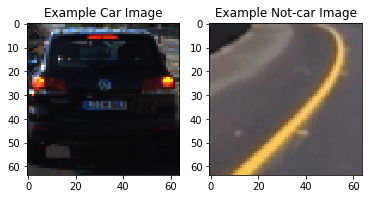

In [2]:
images1 = glob.glob(r'C:\Users\stuar\CarND-Vehicle-Detection_TrainingData\non-vehicles\non-vehicles\**\*.png', recursive=True)
notcars = []
for image in images1:
    notcars.append(image)

images2 = glob.glob(r'C:\Users\stuar\CarND-Vehicle-Detection_TrainingData\vehicles\vehicles\**\*.png', recursive=True)
cars = []
for image in images2:
    cars.append(image)

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    testimg = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = testimg.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = testimg.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = cv2.imread(cars[car_ind])
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
notcar_image = cv2.imread(notcars[notcar_ind])
notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_BGR2RGB)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
fig.savefig('output_images/exampleimages');

Functions to perform image operations, feature extraction, and training the classifier.

In [3]:
#Change color scale of the image
def colorscale(img, color_scale = 'RGB'):
    if color_scale != 'RGB':
        if color_scale == 'gray':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        elif color_scale == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_scale == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_scale == 'LUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_scale == 'YUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_scale == 'YCrCb':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    return img

def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    img = colorscale(img, color_space)
    img = cv2.resize(img, size)
    # Use cv2.resize().ravel() to create the feature vector
    features = img.ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    #Calculate bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        feature_image = colorscale(image, color_scale = cspace)     

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                 
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

def split_scale(car_features, notcar_features):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    return X_train, y_train, X_test, y_test, X_scaler

def train(X_train, y_train, X_test, y_test):
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = len(X_test)
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc

Color histogram of car and not car images.

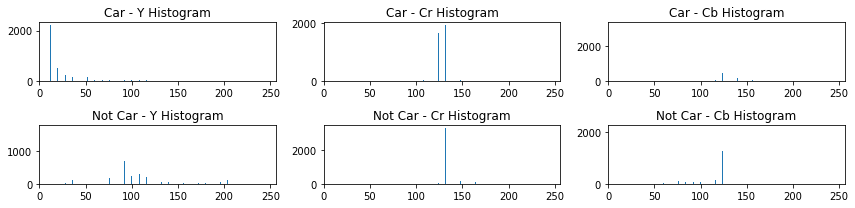

In [21]:
YCrCbcar = colorscale(car_image, color_scale = 'YCrCb')
YCrCbnocar = colorscale(notcar_image, color_scale = 'YCrCb')

channel1_hist_car, channel2_hist_car, channel3_hist_car, bin_centers_car, hist_features_car = color_hist(YCrCbcar, nbins=32, bins_range=(0, 256))
channel1_hist_nocar, channel2_hist_nocar, channel3_hist_nocar, bin_centers_nocar, hist_features_nocar = color_hist(YCrCbnocar, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if channel1_hist_car is not None and channel1_hist_nocar is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(231)
    plt.bar(bin_centers_car, channel1_hist_car[0])
    plt.xlim(0, 256)
    plt.title('Car - Y Histogram')
    plt.subplot(232)
    plt.bar(bin_centers_car, channel2_hist_car[0])
    plt.xlim(0, 256)
    plt.title('Car - Cr Histogram')
    plt.subplot(233)
    plt.bar(bin_centers_car, channel3_hist_car[0])
    plt.xlim(0, 256)
    plt.title('Car - Cb Histogram')
    plt.subplot(234)
    plt.bar(bin_centers_nocar, channel1_hist_nocar[0])
    plt.xlim(0, 256)
    plt.title('Not Car - Y Histogram')
    plt.subplot(235)
    plt.bar(bin_centers_nocar, channel2_hist_nocar[0])
    plt.xlim(0, 256)
    plt.title('Not Car - Cr Histogram')
    plt.subplot(236)
    plt.bar(bin_centers_nocar, channel3_hist_nocar[0])
    plt.xlim(0, 256)
    plt.title('Not Car - Cb Histogram')
    fig.tight_layout()
    fig.savefig('output_images/Hist')
else:
    print('Your function is returning None for at least one variable...')

Extract and visual HOG features.

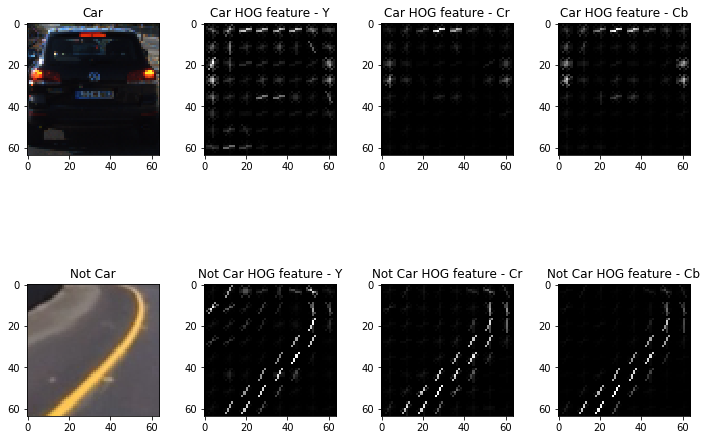

In [5]:
car_image_1 = YCrCbcar[:,:,0]
car_image_2 = YCrCbcar[:,:,1]
car_image_3 = YCrCbcar[:,:,2]

featurescar1, hog_imagecar1 = get_hog_features(car_image_1, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)
featurescar2, hog_imagecar2 = get_hog_features(car_image_2, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)
featurescar3, hog_imagecar3 = get_hog_features(car_image_3, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)

nocar_image_1 = YCrCbnocar[:,:,0]
nocar_image_2 = YCrCbnocar[:,:,1]
nocar_image_3 = YCrCbnocar[:,:,2]
featuresnocar1, hog_imagenocar1 = get_hog_features(nocar_image_1, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)
featuresnocar2, hog_imagenocar2 = get_hog_features(nocar_image_2, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)
featuresnocar3, hog_imagenocar3 = get_hog_features(nocar_image_3, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure(figsize=(10, 8))
plt.subplot(241)
plt.imshow(car_image)
plt.title('Car')
plt.subplot(242)
plt.imshow(hog_imagecar1, cmap='gray')
plt.title('Car HOG feature - Y')
plt.subplot(243)
plt.imshow(hog_imagecar2, cmap='gray')
plt.title('Car HOG feature - Cr')
plt.subplot(244)
plt.imshow(hog_imagecar3, cmap='gray')
plt.title('Car HOG feature - Cb')
plt.subplot(245)
plt.imshow(notcar_image)
plt.title('Not Car')
plt.subplot(246)
plt.imshow(hog_imagenocar1, cmap='gray')
plt.title('Not Car HOG feature - Y')
plt.subplot(247)
plt.imshow(hog_imagenocar2, cmap='gray')
plt.title('Not Car HOG feature - Cr')
plt.subplot(248)
plt.imshow(hog_imagenocar3, cmap='gray')
plt.title('Not Car HOG feature - Cb')
fig.tight_layout()
fig.savefig('output_images/HOG');

Feature extraction from the training set.

In [22]:
### Parameters for HOG feature extraction
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16)
hist_bins = 32
hist_range = (0, 256)
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

notcar_features = extract_features(notcars, cspace=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG and color features...')
print('Feature vector length:', len(car_features[0]))

179.71 Seconds to extract HOG and color features...
Feature vector length: 6156


Split the dataset into training and test sets. Train the classifier and report the accuracy on the test set predictions.

In [7]:
X_train, y_train, X_test, y_test, X_scaler = split_scale(car_features, notcar_features)

In [8]:
svc = train(X_train, y_train, X_test, y_test)

15.35 Seconds to train SVC...
Test Accuracy of SVC =  0.9887
My SVC predicts:  [1. 1. 0. ... 1. 1. 1.]
For these 3552 labels:  [1. 1. 0. ... 1. 1. 1.]
0.03307 Seconds to predict 3552 labels with SVC


In [9]:
# Save the training classifier and properties result
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
dist_pickle["colorspace"] = colorspace
pickle.dump( dist_pickle, open( "svc_pickle.p", "wb" ) )

## Identify Vehicles in Test Images

The following code was adopted from the lessons.

In [10]:
# Function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, colorspace):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = colorscale(img_tosearch, color_scale = colorspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            _, _, _, _, hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, box_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [11]:
# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )

# get attributes of our svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
colorspace = dist_pickle["colorspace"]

Test the sliding window, feature extraction, classification, and false positive rejection pipeline on the test images.

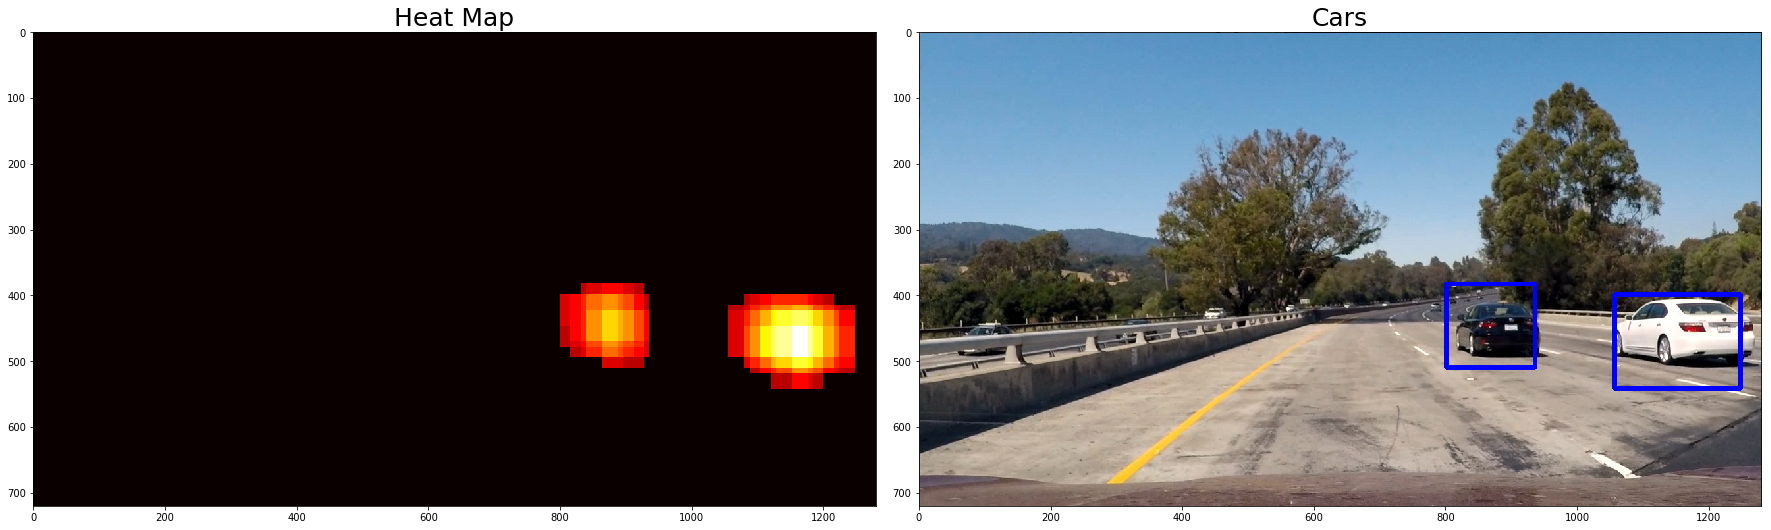

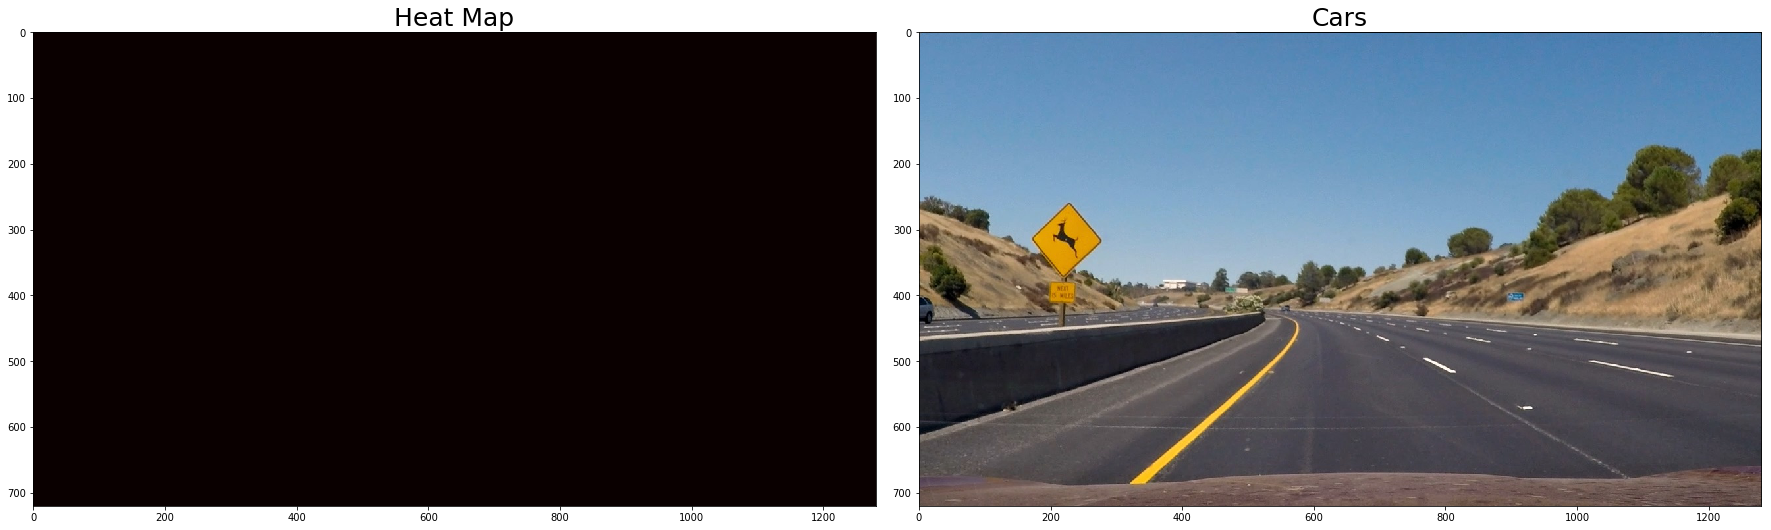

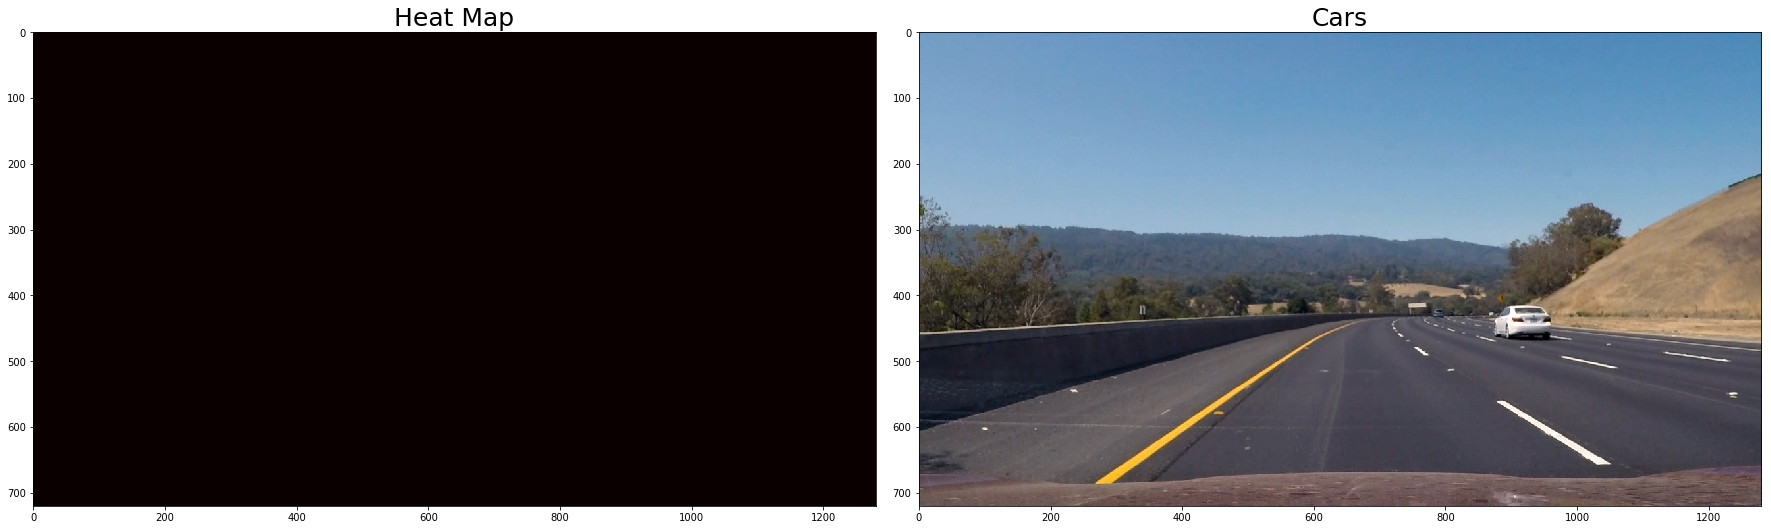

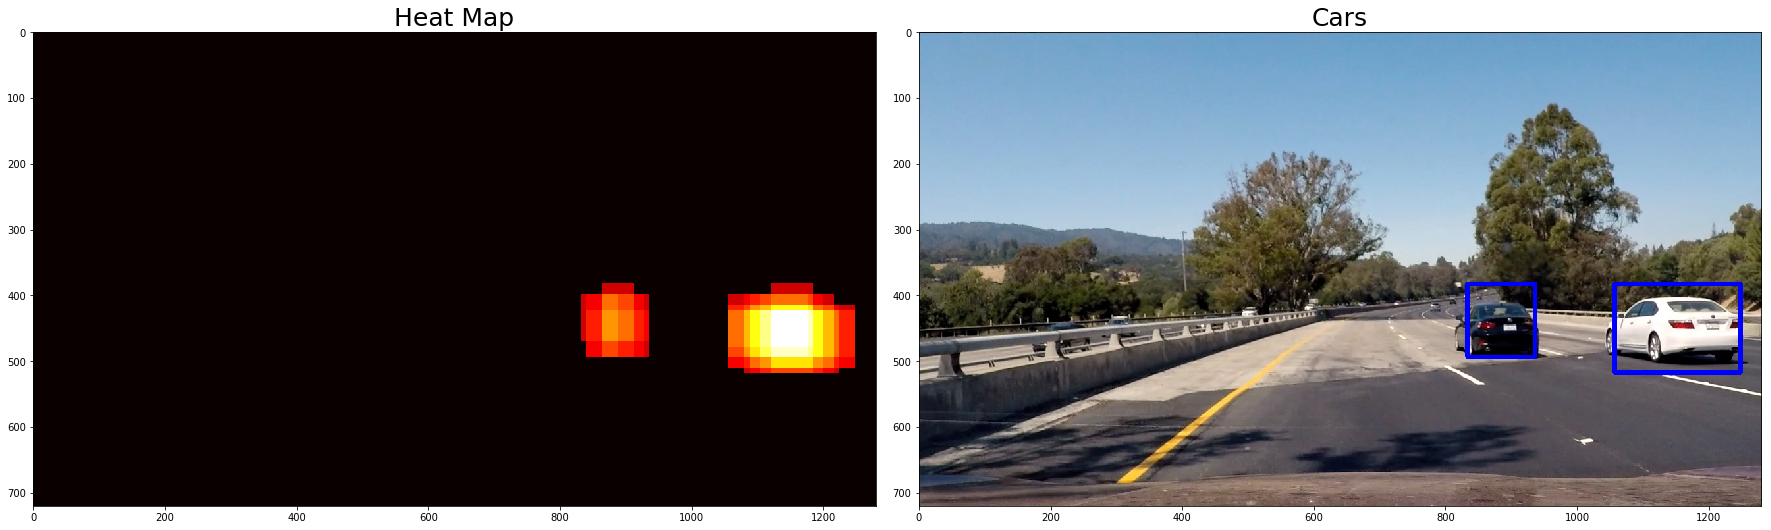

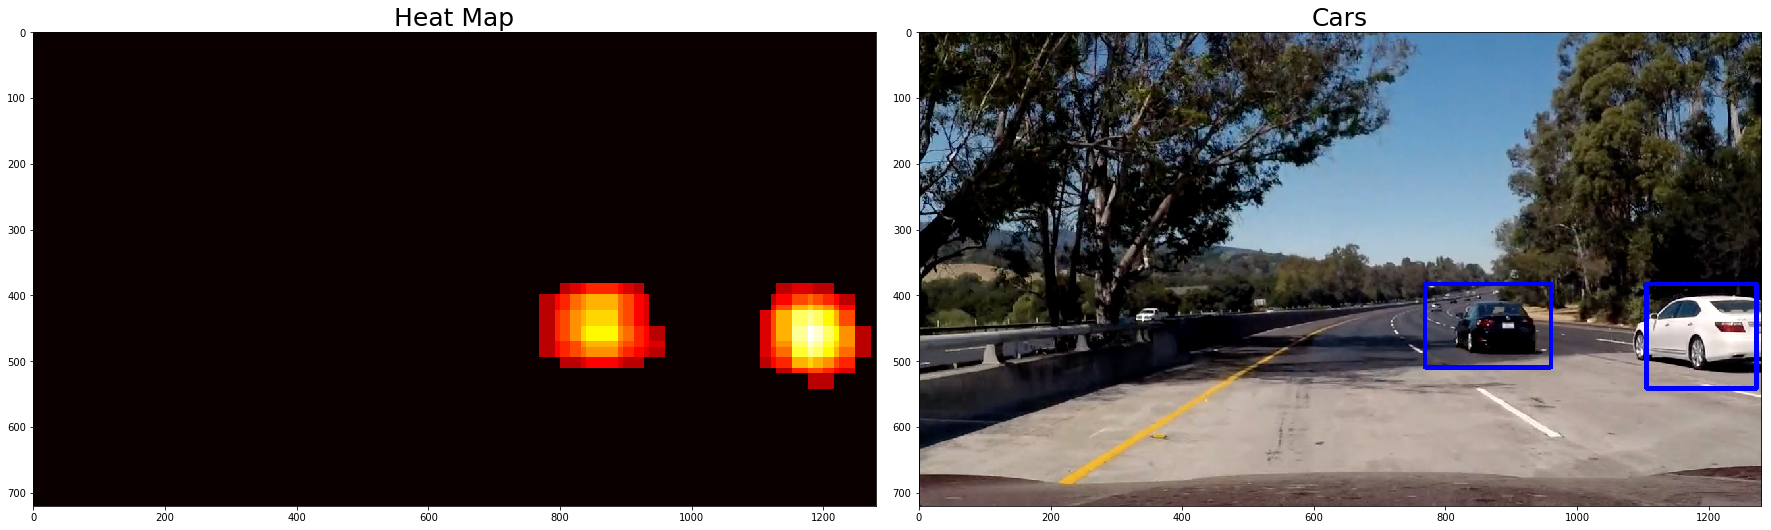

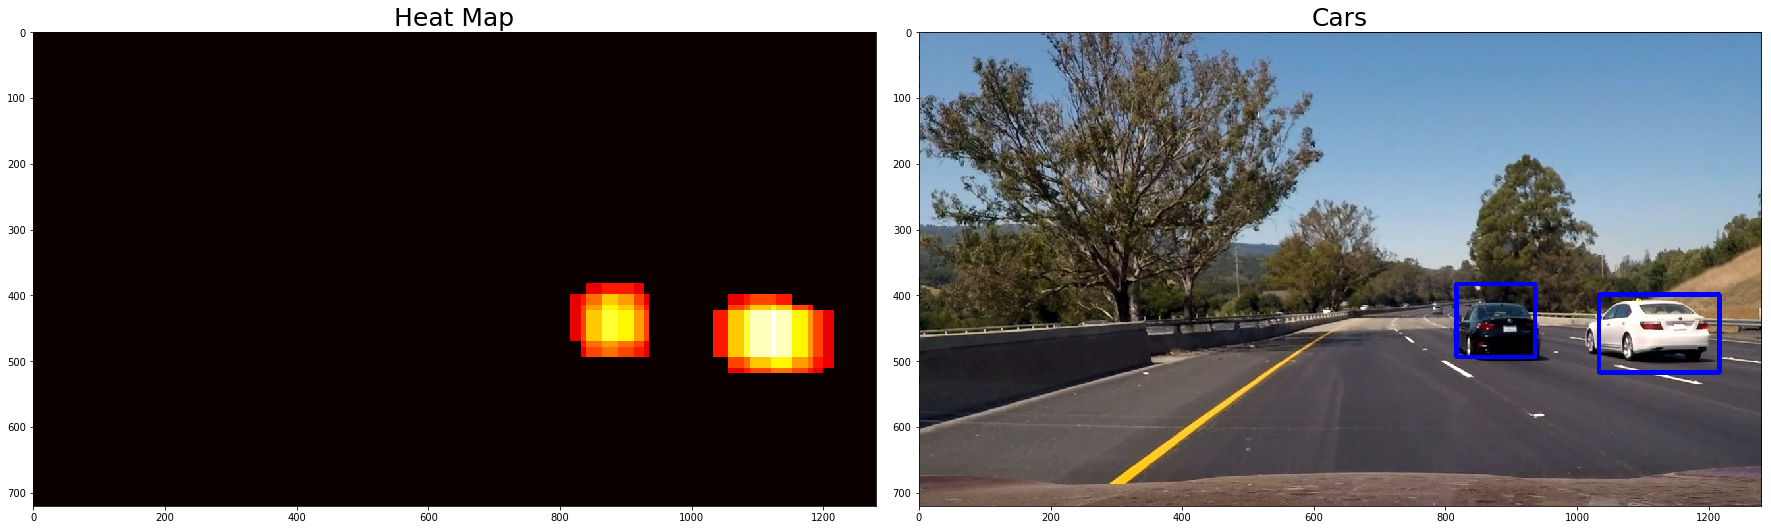

In [12]:
ystart = 350
ystop = 656
scale = [1.5, 2]
i=1
for pic in natsorted(glob.glob('test_images/test*.jpg')):
    img = cv2.imread(pic)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    box_list=[]
    for i in range(len(scale)):
        out_img, box_list_subset = find_cars(img, ystart, ystop, scale[i], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, colorspace)
        box_list.extend(box_list_subset)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,4)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(heatmap, cmap='hot')
    ax1.set_title('Heat Map', fontsize=25)
    
    ax2.imshow(draw_img)
    ax2.set_title('Cars', fontsize=25)
   
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    f.savefig('output_images/detections'+str(i))
    i+=1

In [13]:
# Define a class to receive the characteristics of each frame 
class Frame():
    
    n = 10 #Number of frames to smooth boxes data
    thres = 2
    
    def __init__(self):

        # heat map of previous frames
        self.prev_heatmap = None
        # list of heat maps from previous frames
        self.heatmaps = []
        # heat map of current frame
        self.current_heatmap = None
        # heat maps overlayed over various frames
        self.total_heatmap = None
        self.first_iter = 0
        self.heatmap_corr= None

    
    def Update(self, heatmap):
        self.current_heatmap = heatmap
        self.heatmaps.append(heatmap)
        if len(self.heatmaps) > self.n:
            self.heatmaps.pop(0)
        self.total_heatmap = np.zeros_like(heatmap)
        '''
        for i in range(len(self.heatmaps)):
            self.total_heatmap += self.heatmaps[i]
        self.total_heatmap = np.divide(self.total_heatmap, len(self.heatmaps))
        '''
        self.total_heatmap = np.mean(self.heatmaps, axis = 0)
        #self.total_heatmap = np.array(self.total_heatmap)
        if self.first_iter == 0:
            self.prev_heatmap = np.zeros_like(heatmap)
        self.heatmap_corr = np.copy(heatmap)
        self.heatmap_corr[self.prev_heatmap <= self.thres] = 0
        self.prev_heatmap = np.copy(heatmap)
        
        self.first_iter = 1

In [14]:
def process_image(img):
    global frame
    global svc
    global X_scaler
    global spatial_size
    global hist_bins
    global cell_per_block
    global pix_per_cell
    global orient
    global hist_range
    global colorspace
    ystart = 400
    ystop = 656
    scale = [1, 1.5]
    box_list=[]
    for i in range(len(scale)):
        out_img, box_list_subset = find_cars(img, ystart, ystop, scale[i], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, colorspace)
        box_list.extend(box_list_subset)
        
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    frame.Update(heat)
    # Apply threshold to help remove false positives
    heat = apply_threshold(frame.total_heatmap,7)
    #heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [15]:
# Import everything needed to edit/save/watch video clips# Import 
from moviepy.editor import VideoFileClip, ipython_display
from IPython.display import HTML
import os

directory = 'test_videos_output'
if not os.path.exists(directory):
    os.makedirs(directory)

output_video = 'test_videos_output/test_video.mp4'
clip1 = VideoFileClip("test_video.mp4")

In [16]:
frame = Frame()

output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video test_videos_output/test_video.mp4
[MoviePy] Writing video test_videos_output/test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [02:10<00:03,  3.42s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video.mp4 

Wall time: 2min 10s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [18]:
frame = Frame()
    
output_video = 'test_videos_output/project_video.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(0,10)
clip1 = VideoFileClip("project_video.mp4")

In [19]:
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:11:55<00:03,  3.42s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 1h 11min 55s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))